# 03wk-2: 로지스틱 – 시그모이드, BCELoss, Adam, 로지스틱의 한계 및 극복

최규빈  
2025-03-24

<a href="https://colab.research.google.com/github/guebin/DL2025/blob/main/posts/03wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

In [1]:
# {{<video https://youtu.be/playlist?list=PLQqh36zP38-wO_Mc_74QoweAxCWw5A86_&si=iWAgttM-CIgsi1x3 >}}

# 2. Imports

In [2]:
import torch
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

In [3]:
plt.rcParams['figure.figsize'] = (4.5, 3.0)

# 3. 로지스틱 최초적합

## A. 로지스틱 모형

`-` $x$가 커질수록 (혹은 작아질수록) $y=1$이 잘나오는 모형은 아래와 같이
설계할 수 있음 \<— 외우세요!!!

-   $y_i \sim {\cal B}(\pi_i),\quad$ where
    $\pi_i = \frac{\exp(w_0+w_1x_i)}{1+\exp(w_0+w_1x_i)} = \frac{1}{1+\exp(-w_0-w_1x_i)}$

-   $\hat{y}_i= \frac{\exp(\hat{w}_0+\hat{w}_1x_i)}{1+\exp(\hat{w}_0+\hat{w}_1x_i)}=\frac{1}{1+\exp(-\hat{w}_0-\hat{w}_1x_i)}$

`-` 회귀모형과 로지스틱 모형의 비교

-   회귀모형: $y_i \sim {\cal N}(w_0+w_1x_i, \sigma^2)$[1]
-   로지스틱:
    $y_i \sim {\cal B}\big(\frac{\exp(w_0+w_1x_i)}{1+\exp(w_0+w_1x_i)}\big)$

`-` 우리가 예측하고 싶은것

-   회귀모형: 정규분포의 평균을 예측하고 싶음. 즉 $w_0+w_1x_i$를
    예측하고 싶음. 예측값으로는 $\hat{w}_0 + \hat{w}_1x_i$를 사용!
-   로지스틱: 베르누이의 평균을 예측하고 싶음. 즉
    $\frac{\exp(w_0+w_1x_i)}{1+\exp(w_0+w_1x_i)}$를 예측하고 싶음.
    예측값으로는
    $\frac{\exp(\hat{w}_0+\hat{w}_1x_i)}{1+\exp(\hat{w}_0+\hat{w}_1x_i)}$를
    사용!

## B. 데이터

[1] 원래는 이렇게 썼었지..
$y_i = w_0 + w_1x_i + \epsilon_i \quad \epsilon_i \sim {\cal N}(0,\sigma^2)$

In [6]:
torch.manual_seed(43052)
x = torch.linspace(-1,1,2000).reshape(2000,1)
w0,w1 = -1, 5
prob = torch.exp(w0+w1*x) / (1+torch.exp(w0+w1*x)) 
y = torch.bernoulli(prob)

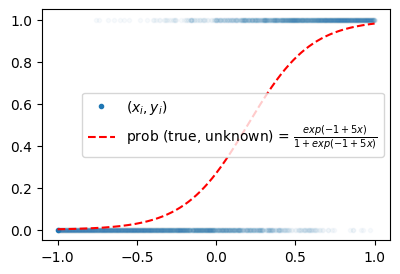

In [7]:
plt.plot(x,y,'.',alpha=0.03)
plt.plot(x[0],y[0],'.',label=r"$(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--r',label=r"prob (true, unknown) = $\frac{exp(-1+5x)}{1+exp(-1+5x)}$")
plt.legend()

## C. Step1: net 설계 (모델링)

`-` 최초의 곡선을 그려보자.

-   최초의직선: $\hat{y}_i= \hat{w}_0+\hat{w}_1x_i$ 에서 아무
    $\hat{w}_0$, $\hat{w}_1$ 을 설정하면 된다.
-   최초의곡선:
    $\hat{y}_i= \frac{\exp(\hat{w}_0+\hat{w}_1x_i)}{1+\exp(\hat{w}_0+\hat{w}_1x_i)}=\frac{1}{1+\exp(-\hat{w}_0-\hat{w}_1x_i)}$
    에서 아무 $\hat{w}_0$, $\hat{w}_1$ 을 설정하면 된다.

> **Note**
>
> 일단은 초기 설정값을 $\hat{w}_0 = -0.8$, $\hat{w}_1 = -0.3$ 으로 하자.
> (실제값은 $w_0=-1$, $w_1=5$ 이다)

`# 방법1` – l1, sigmoid

In [8]:
l1 = torch.nn.Linear(1,1)
l1(x)

In [9]:
l1.weight.data = torch.tensor([[-0.3]])
l1.bias.data = torch.tensor([-0.8])

In [10]:
def sigmoid(x):
    return torch.exp(x)/(1+torch.exp(x))

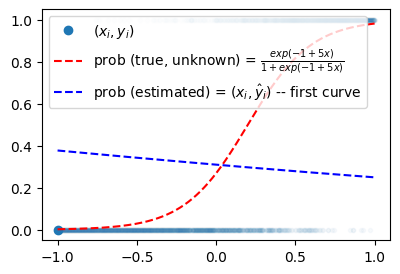

In [13]:
plt.plot(x,y,'.',alpha=0.03)
plt.plot(x[0],y[0],'o',label=r"$(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--r',label=r"prob (true, unknown) = $\frac{exp(-1+5x)}{1+exp(-1+5x)}$")
plt.plot(x,sigmoid(l1(x)).data,'--b', label=r"prob (estimated) = $(x_i,\hat{y}_i)$ -- first curve")
plt.legend()

`#`

`# 방법2` – l1, a1

In [14]:
l1 = torch.nn.Linear(1,1)
l1.weight.data = torch.tensor([[-0.3]])
l1.bias.data = torch.tensor([-0.8])

In [15]:
a1 = torch.nn.Sigmoid()

In [16]:
sigmoid(l1(x)), a1(l1(x)) # 똑같아요

`-` 지금까지의 구현 확인

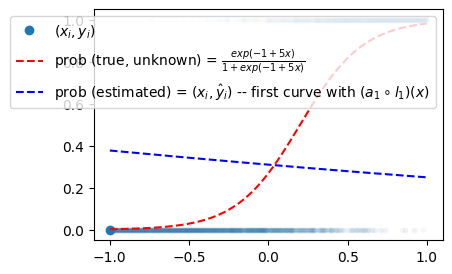

In [17]:
plt.plot(x,y,'.',alpha=0.03)
plt.plot(x[0],y[0],'o',label=r"$(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--r',label=r"prob (true, unknown) = $\frac{exp(-1+5x)}{1+exp(-1+5x)}$")
plt.plot(x,a1(l1(x)).data,'--b', label=r"prob (estimated) = $(x_i,\hat{y}_i)$ -- first curve with $(a_1 \circ l_1)(x)$")
plt.legend()

`#`

`# 방법3` - l1, a1 만들고 $\to$ net

`-` 관찰: 지금 아래의 구조이다.

$${\bf x} \overset{l_1}{\to} {\bf u} \overset{a_1}{\to} {\bf v} = \hat{\bf y}$$

`-` 소망: 함수 $l_1, a_1$ 의 합성을 하나로 묶어서

$$(a_1\circ l_1)({\bf x}) := net({\bf x})$$

이러한 기능을 하는 하나의 함수 $net$을 만들 수 없을까?

In [18]:
l1 = torch.nn.Linear(1,1)
l1.weight.data = torch.tensor([[-0.3]])
l1.bias.data = torch.tensor([-0.8])
a1 = torch.nn.Sigmoid()

In [19]:
net = torch.nn.Sequential(l1,a1) #l1을 취하고 그다음에 a1을 취하라는 의미

In [20]:
net(x), a1(l1(x)), sigmoid(l1(x))

`*` net 구조 잠깐 살펴보기

In [21]:
net[0], net[1]

In [22]:
l1 is net[0]

In [23]:
a1 is net[1]

`#`

`# 방법4` – net을 바로 만들기

In [24]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
)

In [25]:
net[0],net[1] 

In [26]:
l1, a1 = net 

In [27]:
l1.weight, l1.bias

In [28]:
l1.weight.data = torch.tensor([[-0.3]])
l1.bias.data = torch.tensor([-0.8])

In [29]:
net(x)

`#`

## D. Step1~4

In [37]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1, out_features=1),
    torch.nn.Sigmoid()
)
l1, a1 = net 
l1.weight.data = torch.tensor([[-0.3]])
l1.bias.data = torch.tensor([-0.8])
optimizr = torch.optim.SGD(net.parameters(),lr=0.25)
#---#
for epoc in range(100):
    ## 1
    yhat = net(x) 
    ## 2 
    loss = torch.mean((y-yhat)**2)
    ## 3
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

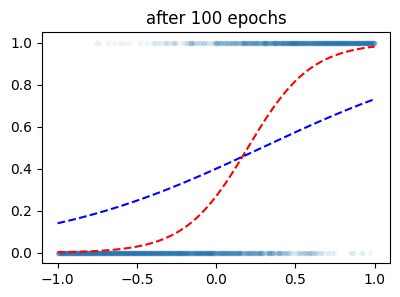

In [38]:
plt.plot(x,y,'.',alpha=0.05)
plt.plot(x,prob,'--r')
plt.plot(x,yhat.data,'--b')
plt.title('after 100 epochs')

In [39]:
for epoc in range(4900):
    ## 1
    yhat = net(x) 
    ## 2 
    loss = torch.mean((y-yhat)**2)
    ## 3
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

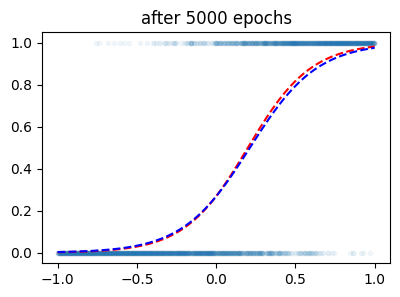

In [40]:
plt.plot(x,y,'.',alpha=0.05)
plt.plot(x,prob,'--r')
plt.plot(x,yhat.data,'--b')
plt.title('after 5000 epochs')

# 4. 학습과정 시각화 및 문제인식

## A. 시각화를 위한 준비

In [41]:
def plot_loss(loss_fn, ax=None, Wstar=[-1,5]):
    w0hat,w1hat =torch.meshgrid(torch.arange(-10,3,0.1),torch.arange(-1,10,0.1),indexing='ij')
    w0hat = w0hat.reshape(-1)
    w1hat = w1hat.reshape(-1)
    def l(w0hat,w1hat):
        yhat = torch.exp(w0hat+w1hat*x)/(1+torch.exp(w0hat+w1hat*x))
        return loss_fn(yhat,y) 
    loss = list(map(l,w0hat,w1hat))
    #---#
    if ax is None: 
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1,projection='3d')
    ax.scatter(w0hat,w1hat,loss,s=0.001) 
    ax.scatter(w0hat[::20],w1hat[::20],loss[::20],s=0.1,color='C0') 
    w0star,w1star = np.array(Wstar).reshape(-1)
    ax.scatter(w0star,w1star,l(w0star,w1star),s=200,marker='*',color='red',label=f"W=[{w0star:.1f},{w1star:.1f}]")
    #---#
    ax.elev = 15
    ax.dist = -20
    ax.azim = 75    
    ax.legend()
    ax.set_xlabel(r'$w_0$')  # x축 레이블 설정
    ax.set_ylabel(r'$w_1$')  # y축 레이블 설정
    ax.set_xticks([-10,-5,0])  # x축 틱 간격 설정
    ax.set_yticks([-10,0,10])  # y축 틱 간격 설정

In [48]:
def _learn_and_record(net, loss_fn, optimizr):
    yhat_history = [] 
    loss_history = []
    What_history = []
    Whatgrad_history = []
    What_history.append([net[0].bias.data.item(), net[0].weight.data.item()])
    for epoc in range(100): 
        ## step1 
        yhat = net(x)
        ## step2 
        loss = loss_fn(yhat,y)
        ## step3
        loss.backward() 
        ## step4 
        optimizr.step()
        ## record 
        if epoc % 5 ==0: 
            yhat_history.append(yhat.reshape(-1).data.tolist())
            loss_history.append(loss.item())
            What_history.append([net[0].bias.data.item(), net[0].weight.data.item()])
            Whatgrad_history.append([net[0].bias.grad.item(), net[0].weight.grad.item()])
        optimizr.zero_grad() 
        
    return yhat_history, loss_history, What_history, Whatgrad_history
    
def show_animation(net, loss_fn, optimizr):
    yhat_history,loss_history,What_history,Whatgrad_history = _learn_and_record(net,loss_fn,optimizr)
    
    fig = plt.figure(figsize=(7.5,3.5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ## ax1: 왼쪽그림 
    ax1.scatter(x,y,alpha=0.01)
    ax1.scatter(x[0],y[0],color='C0',label=r"observed data = $(x_i,y_i)$")
    ax1.plot(x,prob,'--',label=r"prob (true) = $(x_i,\frac{exp(-1+5x_i)}{1+exp(-1+5x_i)})$")    
    line, = ax1.plot(x,yhat_history[0],'--',label=r"prob (estimated) = $(x_i,\hat{y}_i)$") 
    ax1.legend()
    ## ax2: 오른쪽그림 
    plot_loss(loss_fn,ax2)
    ax2.scatter(np.array(What_history)[0,0],np.array(What_history)[0,1],loss_history[0],color='blue',s=200,marker='*')    
    def animate(epoc):
        line.set_ydata(yhat_history[epoc])
        w0hat = np.array(What_history)[epoc,0]
        w1hat = np.array(What_history)[epoc,1]
        w0hatgrad = np.array(Whatgrad_history)[epoc,0]
        w1hatgrad = np.array(Whatgrad_history)[epoc,1]
        ax2.scatter(w0hat,w1hat,loss_history[epoc],color='grey')
        ax2.set_title(f"What.grad=[{w0hatgrad:.4f},{w1hatgrad:.4f}]",y=0.8)
        fig.suptitle(f"epoch={epoc*5} // What=[{w0hat:.2f},{w1hat:.2f}] // Loss={loss_fn.__class__.__name__} // Opt={optimizr.__class__.__name__}")
        return line
    ani = animation.FuncAnimation(fig, animate, frames=20)    
    plt.close()
    return ani

In [49]:
from matplotlib import animation
plt.rcParams["animation.html"] = "jshtml"

*함수사용법*

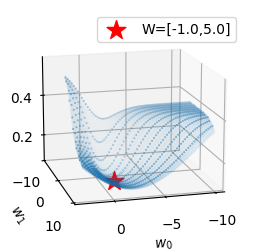

In [50]:
loss_fn = torch.nn.MSELoss()
plot_loss(loss_fn)

In [51]:
torch.manual_seed(42)
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
show_animation(net,loss_fn,optimizr)

## B. 좋은 초기값

In [52]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-0.8])
net[0].weight.data = torch.tensor([[-0.3]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

## C. 가능성 있는 초기값

In [53]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-3.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

## D. 최악의 초기값

In [54]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-10.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

해결하는 접근법:

-   컴공스타일: 에폭을 늘려볼까?
-   산공스타일: 옵티마이저를 바꿔볼까?
-   통계스타일: Loss를 바꿔볼까?

# 5. 손실함수의 개선

## A. BCE Loss를 사용하여 학습

`-` BCE loss라는게 있음.

-   $loss= - \sum_{i=1}^{n} \big(y_i\log(\hat{y}_i)+(1-y_i)\log(1-\hat{y}_i)\big)$
-   <https://en.wikipedia.org/wiki/Cross-entropy>

In [55]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1, out_features=1),
    torch.nn.Sigmoid()
)
l1, a1 = net 
l1.weight.data = torch.tensor([[-0.3]])
l1.bias.data = torch.tensor([-0.8])
optimizr = torch.optim.SGD(net.parameters(),lr=0.25)
#---#
for epoc in range(100):
    ## 1
    yhat = net(x) 
    ## 2 
    #loss = torch.mean((y-yhat)**2)
    loss = -torch.mean(y*torch.log(yhat) + (1-y)*torch.log(1-yhat))
    ## 3
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

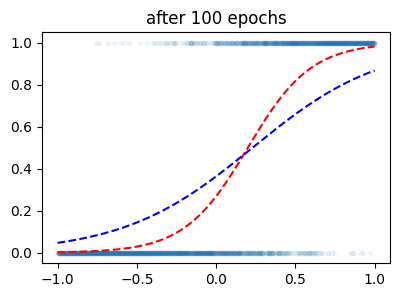

In [57]:
plt.plot(x,y,'.',alpha=0.05)
plt.plot(x,prob,'--r')
plt.plot(x,yhat.data,'--b')
plt.title('after 100 epochs')

같은 100 에폭인데 훨씬 잘맞춤..

`-` loss수식을 못외우겠다면?

In [58]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1, out_features=1),
    torch.nn.Sigmoid()
)
l1, a1 = net 
l1.weight.data = torch.tensor([[-0.3]])
l1.bias.data = torch.tensor([-0.8])
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25)
#---#
for epoc in range(100):
    ## 1
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y) # yhat부터 써야함
    ## 3
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

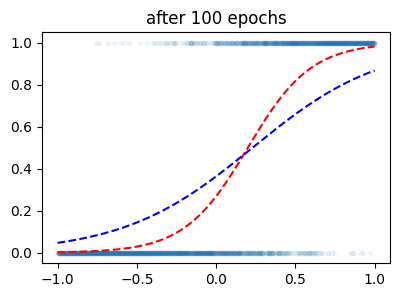

In [60]:
plt.plot(x,y,'.',alpha=0.05)
plt.plot(x,prob,'--r')
plt.plot(x,yhat.data,'--b')
plt.title('after 100 epochs')

## B. Loss Function 시각화

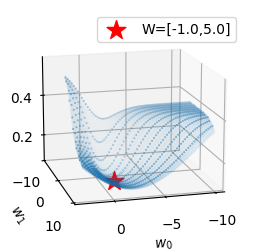

In [61]:
plot_loss(torch.nn.MSELoss())

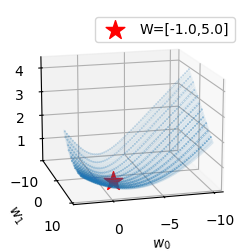

In [62]:
plot_loss(torch.nn.BCELoss())

`-` 비교해보자.

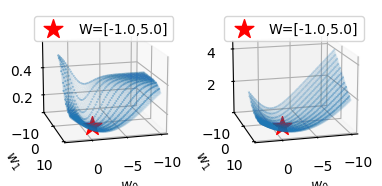

In [63]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax2 = fig.add_subplot(1,2,2,projection='3d')
plot_loss(torch.nn.MSELoss(),ax1)
plot_loss(torch.nn.BCELoss(),ax2)

## C. 학습과정 시각화 – 좋은 초기값

`-` MSELoss

In [64]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-0.8])
net[0].weight.data = torch.tensor([[-0.3]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

`-` BCELoss

In [65]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-0.8])
net[0].weight.data = torch.tensor([[-0.3]])
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

## D. 학습과정 시각화 – 가능성 있는 초기값

`-` MSELoss

In [66]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-3.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

`-` BCELoss

In [67]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-3.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

## E. 학습과정 시각화 – 최악의 초기값

`-` MSELoss

In [68]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-10.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

`-` BCELoss

In [69]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-10.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

# 6. 옵티마이저의 개선

## A. 학습과정 시각화 – 좋은 초기값

`-` MSELoss + SGD

In [70]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-0.8470])
net[0].weight.data = torch.tensor([[-0.3467]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

`-` MSELoss + Adam

In [71]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-0.8])
net[0].weight.data = torch.tensor([[-0.3]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

## B. 학습과정 시각화 – 가능성 있는 초기값

`-` MSELoss + SGD

In [72]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-3.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

`-` MSELoss + Adam

In [73]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-3.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

## C. 학습과정 시각화 – 최악의 초기값

`-` MSELoss + SGD

In [74]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-10.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.05) 
#---#
show_animation(net,loss_fn,optimizr)

`-` MSELoss + Adam

In [75]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
net[0].bias.data = torch.tensor([-10.0])
net[0].weight.data = torch.tensor([[-1.0]])
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.25) 
#---#
show_animation(net,loss_fn,optimizr)

## D. 참고자료

<https://www.youtube.com/watch?v=MD2fYip6QsQ>

-   11:50 – Momentum
-   12:30 – RMSprop
-   15:55 – Adam

# 7. 로지스틱의 한계

## A. 신문기사 (데이터의 모티브)

`-` [스펙이 높아도 취업이 안된다고
합니다..](https://www.joongang.co.kr/article/23637092#home)

**중소·지방 기업 “뽑아봤자 그만두니까”**

중소기업 관계자들은 고스펙 지원자를 꺼리는 이유로 높은 퇴직률을 꼽는다.
여건이 좋은 대기업으로 이직하거나 회사를 관두는 경우가 많다는
하소연이다. 고용정보원이 지난 3일 공개한 자료에 따르면 중소기업
청년취업자 가운데 49.5%가 2년 내에 회사를 그만두는 것으로 나타났다.

중소 IT업체 관계자는 “기업 입장에서 가장 뼈아픈 게 신입사원이 그만둬서
새로 뽑는 일”이라며 “명문대 나온 스펙 좋은 지원자를 뽑아놔도 1년을
채우지 않고 그만두는 사원이 대부분이라 우리도 눈을 낮춰 사람을 뽑는다”고
말했다.

## B. 가짜데이터

In [76]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DL2024/main/posts/dnnex.csv")
df

In [77]:
x = torch.tensor(df.x).float().reshape(-1,1)
y = torch.tensor(df.y).float().reshape(-1,1)
prob = torch.tensor(df.prob).float().reshape(-1,1)

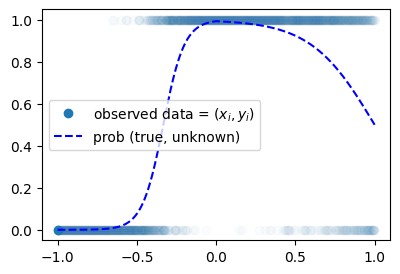

In [78]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x[0],y[0],'o',label= r"observed data = $(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--b',label= r"prob (true, unknown)")
plt.legend()

## C. 로지스틱으로 적합

In [79]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())
#---# 
for epoc in range(5000):
    ## 1 
    yhat = net(x)
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

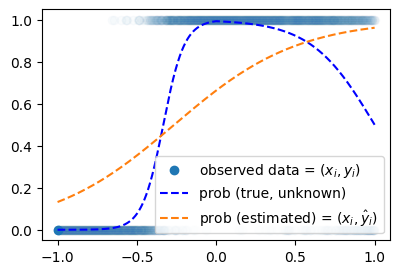

In [80]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x[0],y[0],'o',label= r"observed data = $(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--b',label= r"prob (true, unknown)")
plt.plot(x,net(x).data, '--', label= r"prob (estimated) = $(x_i,\hat{y}_i)$")
plt.legend()

`-` Epoch을 10억번으로 설정해도 이건 못 맞출것 같음.

# 8. 로지스틱의 한계 극복

## A. 아이디어

`-` sigmoid를 넣기 전의 상태가 직선이 아니라 꺽이는 직선이야 한다.

In [81]:
a = torch.nn.Sigmoid()

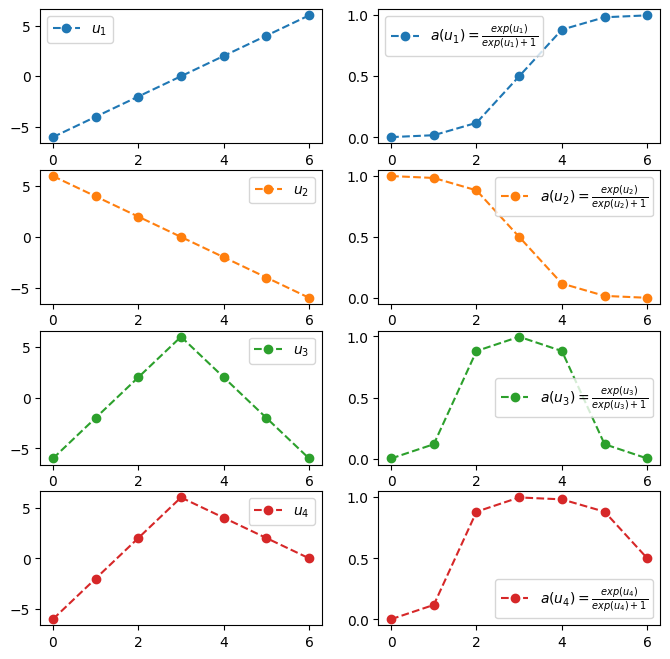

In [82]:
fig,ax = plt.subplots(4,2,figsize=(8,8))
u1 = torch.tensor([-6,-4,-2,0,2,4,6])
u2 = torch.tensor([6,4,2,0,-2,-4,-6])
u3 = torch.tensor([-6,-2,2,6,2,-2,-6])
u4 = torch.tensor([-6,-2,2,6,4,2,0])
ax[0,0].plot(u1,'--o',color='C0',label = r"$u_1$")
ax[0,0].legend()
ax[0,1].plot(a(u1),'--o',color='C0',label = r"$a(u_1)=\frac{exp(u_1)}{exp(u_1)+1}$")
ax[0,1].legend()
ax[1,0].plot(u2,'--o',color='C1',label = r"$u_2$")
ax[1,0].legend()
ax[1,1].plot(a(u2),'--o',color='C1',label = r"$a(u_2)=\frac{exp(u_2)}{exp(u_2)+1}$")
ax[1,1].legend()
ax[2,0].plot(u3,'--o',color='C2', label = r"$u_3$")
ax[2,0].legend()
ax[2,1].plot(a(u3),'--o',color='C2', label = r"$a(u_3)=\frac{exp(u_3)}{exp(u_3)+1}$")
ax[2,1].legend()
ax[3,0].plot(u4,'--o',color='C3', label = r"$u_4$")
ax[3,0].legend()
ax[3,1].plot(a(u4),'--o',color='C3', label = r"$a(u_4)=\frac{exp(u_4)}{exp(u_4)+1}$")
ax[3,1].legend()

## B. 꺽인그래프를 만드는 방법

`-` 로지스틱의 한계를 극복하기 위해서는 시그모이드를 취하기 전에 꺽인
그래프 모양을 만드는 기술이 있어야겠음.

`-` 아래와 같은 벡터 ${\bf x}$를 가정하자.

In [83]:
x = torch.linspace(-1,1,1001).reshape(-1,1)
x

`-` 목표: 아래와 같은 벡터 ${\bf y}$를 만들어보자.

$${\bf y} = [y_1,y_2,\dots,y_{n}]^\top, \quad y_i = \begin{cases} 9x_i +4.5& x_i <0 \\ -4.5x_i + 4.5& x_i >0 \end{cases}$$

> **Caution**
>
> 여기에서 $({\bf x},{\bf y})$ 는 (독립변수,종속변수) 혹은
> (설명변수,반응변수) 를 의미하는게 아님.

`# 방법1` – 수식 그대로 구현

In [84]:
y = x*0 
y[x<0] = (9*x+4.5)[x<0]
y[x>0] = (-4.5*x+4.5)[x>0]

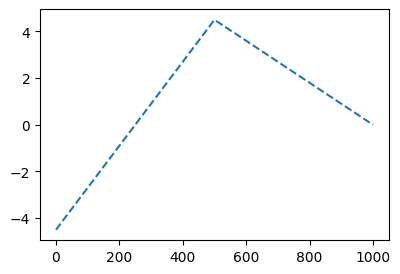

In [85]:
plt.plot(y,'--')

`#`

`# 방법2` – 렐루이용

In [86]:
relu = torch.nn.ReLU()

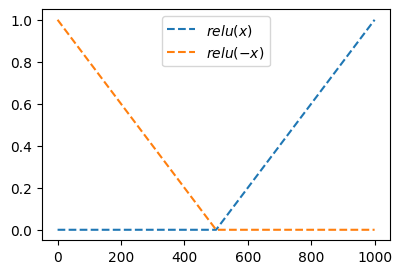

In [87]:
plt.plot(relu(x),'--',label=r'$relu(x)$')
plt.plot(relu(-x),'--',label=r'$relu(-x)$')
plt.legend()

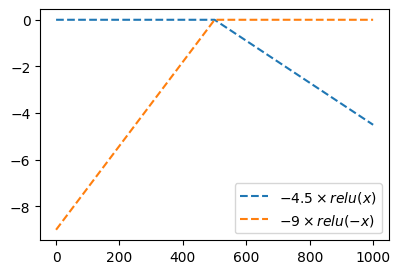

In [88]:
plt.plot(-4.5*relu(x),'--',label=r'$-4.5\times relu(x)$')
plt.plot(-9*relu(-x),'--',label=r'$-9\times relu(-x)$')
plt.legend()

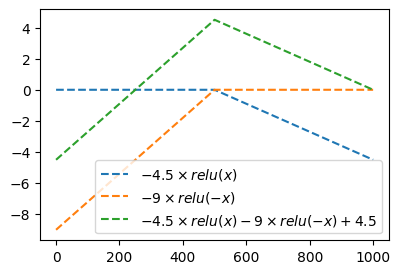

In [89]:
plt.plot(-4.5*relu(x),'--',label=r'$-4.5\times relu(x)$')
plt.plot(-9*relu(-x),'--',label=r'$-9\times relu(-x)$')
plt.plot(-4.5*relu(x)-9*relu(-x)+4.5,'--',label=r'$-4.5\times relu(x) -9 \times relu(-x)+4.5$')
plt.legend()

`-` 시각화

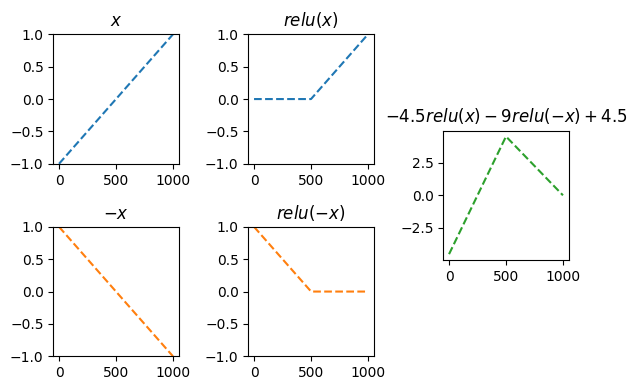

In [90]:
fig = plt.figure(figsize=(6, 4))
spec = fig.add_gridspec(4, 3)
ax1 = fig.add_subplot(spec[:2,0]); ax1.set_title(r'$x$'); ax1.set_ylim(-1,1)
ax2 = fig.add_subplot(spec[2:,0]); ax2.set_title(r'$-x$'); ax2.set_ylim(-1,1)
ax3 = fig.add_subplot(spec[:2,1]); ax3.set_title(r'$relu(x)$'); ax3.set_ylim(-1,1)
ax4 = fig.add_subplot(spec[2:,1]); ax4.set_title(r'$relu(-x)$'); ax4.set_ylim(-1,1)
ax5 = fig.add_subplot(spec[1:3,2]); ax5.set_title(r'$-4.5 relu(x)-9 relu(-x)+4.5$')
#---#
ax1.plot(x,'--',color='C0')
ax2.plot(-x,'--',color='C1')
ax3.plot(relu(x),'--',color='C0')
ax4.plot(relu(-x),'--',color='C1')
ax5.plot(-4.5*relu(x)-9*relu(-x)+4.5,'--',color='C2')
fig.tight_layout()

`#`

`# 방법3` – 방법2의 다른구현!

`-` 렐루이용하여 만드는 방법 정리

1.  벡터 x와 relu함수를 준비한다.
2.  u = \[x,-x\] 를 계산한다.
3.  v = \[relu(x), relu(-x)\] 를 계산한다.
4.  y = -4.5 \* relu(x) + 9 \* relu(-x) +4.5 를 계산한다.

`-` 1단계

In [91]:
x,relu

`-` 2단계

In [92]:
u = torch.concat([x,-x],axis=1) # u = [x, -x] 같은것
u

`-` 3단계

In [93]:
v = relu(u) # 각각의 column에 렐루취함
v

`-` 4단계

In [94]:
-4.5 * v[:,[0]] - 9.0 * v[:,[1]] +4.5

In [95]:
y

`#`

`# 방법4` – 방법3의 다른구현!

`-` 그런데, 방법3의 4단계는 아래와 같이 볼 수 있다.

In [96]:
# -4.5 * v[:,[0]] - 9.0 * v[:,[1]] +4.5

-   ${\bf v}\begin{bmatrix} -4.5 \\ -9.0 \end{bmatrix} + 4.5 = \begin{bmatrix}
    v_{11} & v_{12}  \\
    v_{21} & v_{22}  \\
    \dots & \dots  \\
    v_{n1} & v_{n2}  \\
    \end{bmatrix}\begin{bmatrix} -4.5 \\ -9.0 \end{bmatrix} + 4.5 =
    \begin{bmatrix}
    -4.5 v_{11} - 9.0 v_{12} + 4.5  \\
    -4.5 v_{21} - 9.0 v_{22} + 4.5  \\
    \dots \\
    -4.5 v_{n1} - 9.0 v_{n2} + 4.5 \\
    \end{bmatrix}$

`-` 위의 수식을 참고하여 매트릭스의 곱 형태로 다시 포현하면 아래와 같다.

In [97]:
#-4.5 * v[:,[0]] - 9.0 * v[:,[1]] +4.5
What = torch.tensor([[-4.5],[-9.0]]) 
v @ What + 4.5 

`-` 이제 매트릭스의 곱 대신에 `torch.nn.Linear()`를 이용하면 아래의
코드와 같아진다.

In [98]:
l2 = torch.nn.Linear(
    in_features=2,
    out_features=1 
)

In [99]:
l2.weight.data = torch.tensor([[-4.5,-9.0]])
l2.bias.data = torch.tensor([4.5])

In [100]:
l2(v)

`-` 정리하면

In [101]:
u = torch.concat([x,-x],axis=1)
v = relu(u)
l2 = torch.nn.Linear(
    in_features=2,
    out_features=1 
)
l2.weight.data = torch.tensor([[-4.5,-9.0]])
l2.bias.data = torch.tensor([4.5])
l2(v)

`#`

`# 방법5` – 방법3의 또 다른 구현

`-` 사실 방법3의 2단계도 아래와 같이 볼 수 있다.

$$\begin{bmatrix}
x_1 \\
x_2 \\
\dots \\ 
x_n 
\end{bmatrix}\begin{bmatrix} 1 & -1 \end{bmatrix} = \begin{bmatrix} x_1 & -x_1 \\ x_2 & -x_2 \\ \dots & \dots \\ x_n & -x_n \end{bmatrix}$$

In [102]:
#u = torch.concat([x,-x],axis=1) # u1 = [x, -x] 같은것

In [103]:
l1 = torch.nn.Linear(1,2)
l1.weight.data = torch.tensor([[1.0],[-1.0]])
l1.bias.data = torch.tensor([0.0,0.0])

In [104]:
l1(x)

`-` 따라서 `torch.nn` 에 포함된 레이어를 이용하면 아래와 같이 표현할 할
수 있다.

In [105]:
l1 = torch.nn.Linear(1,2)
l1.weight.data = torch.tensor([[1.0],[-1.0]])
l1.bias.data = torch.tensor([0.0,0.0])
a1 = torch.nn.ReLU()
l2 = torch.nn.Linear(2,1)
l2.weight.data = torch.tensor([[-4.5,-9.0]])
l2.bias.data = torch.tensor([4.5])

In [106]:
l2(a1(l1(x))), y

`#`

`# 방법6` – net를 이용

`-` 각각의 layer를 `torch.nn.Sequential()` 로 묶으면 아래와 같이 정리할
수 있다.

In [107]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,2),
    torch.nn.ReLU(),
    torch.nn.Linear(2,1)
)
l1,a1,l2 = net
l1.weight.data = torch.tensor([[1.0],[-1.0]])
l1.bias.data = torch.tensor([0.0,0.0])
l2.weight.data = torch.tensor([[-4.5,-9.0]])
l2.bias.data = torch.tensor([4.5])

In [108]:
net(x),y

`#`

> **Note**
>
> ***수식표현***
>
> `(1)` ${\bf X}=\begin{bmatrix} x_1 \\ \dots \\ x_n \end{bmatrix}$
>
> `(2)`
> $l_1({\bf X})={\bf X}{\bf W}^{(1)}\overset{bc}{+} {\boldsymbol b}^{(1)}=\begin{bmatrix} x_1 & -x_1 \\ x_2 & -x_2 \\ \dots & \dots \\ x_n & -x_n\end{bmatrix}$
>
> -   ${\bf W}^{(1)}=\begin{bmatrix} 1 & -1 \end{bmatrix}$
> -   ${\boldsymbol b}^{(1)}=\begin{bmatrix} 0 & 0 \end{bmatrix}$
>
> `(3)`
> $(a_1\circ l_1)({\bf X})=\text{relu}\big({\bf X}{\bf W}^{(1)}\overset{bc}{+}{\boldsymbol b}^{(1)}\big)=\begin{bmatrix} \text{relu}(x_1) & \text{relu}(-x_1) \\ \text{relu}(x_2) & \text{relu}(-x_2) \\ \dots & \dots \\ \text{relu}(x_n) & \text{relu}(-x_n)\end{bmatrix}$
>
> `(4)`
> $(l_2 \circ a_1\circ l_1)({\bf X})=\text{relu}\big({\bf X}{\bf W}^{(1)}\overset{bc}{+}{\boldsymbol b}^{(1)}\big){\bf W}^{(2)}\overset{bc}{+}b^{(2)}$
>
> $\quad=\begin{bmatrix} -4.5\times\text{relu}(x_1) -9.0 \times \text{relu}(-x_1) +4.5 \\ -4.5\times\text{relu}(x_2) -9.0 \times\text{relu}(-x_2) + 4.5 \\ \dots \\ -4.5\times \text{relu}(x_n) -9.0 \times\text{relu}(-x_n)+4.5 \end{bmatrix}$
>
> -   ${\bf W}^{(2)}=\begin{bmatrix} -4.5 \\ -9 \end{bmatrix}$
> -   $b^{(2)}=4.5$
>
> `(5)`
> $net({\bf X})=(l_2 \circ a_1\circ l_1)({\bf X})=\text{relu}\big({\bf X}{\bf W}^{(1)}\overset{bc}{+}{\boldsymbol b}^{(1)}\big){\bf W}^{(2)}\overset{bc}{+}b^{(2)}$
>
> $\quad =\begin{bmatrix} -4.5\times\text{relu}(x_1) -9.0 \times \text{relu}(-x_1) +4.5 \\ -4.5\times\text{relu}(x_2) -9.0 \times\text{relu}(-x_2) + 4.5 \\ \dots \\ -4.5\times \text{relu}(x_n) -9.0 \times\text{relu}(-x_n)+4.5 \end{bmatrix}$

## C. Step 1~4

`-` 다시한번 데이터 정리

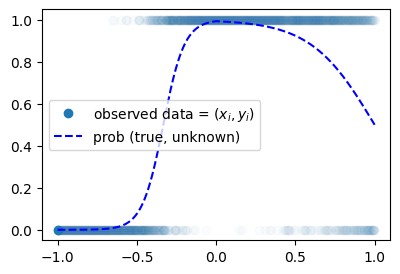

In [109]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DL2024/main/posts/dnnex.csv")
x = torch.tensor(df.x).float().reshape(-1,1)
y = torch.tensor(df.y).float().reshape(-1,1)
prob = torch.tensor(df.prob).float().reshape(-1,1)
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x[0],y[0],'o',label= r"observed data = $(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--b',label= r"prob (true, unknown)")
plt.legend()

`-` Step1에 대한 생각: 네트워크를 어떻게 만들까? = 아키텍처를 어떻게
만들까? = 모델링

$$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,2)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,2)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{a_2}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$$

`-` Step2,3,4 는 너무 뻔해서..

In [110]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(1,2),
    torch.nn.ReLU(),
    torch.nn.Linear(2,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
for epoc in range(3000):
    ## 
    yhat = net(x)
    ## 
    loss = loss_fn(yhat,y)
    ## 
    loss.backward()
    ## 
    optimizr.step()
    optimizr.zero_grad()

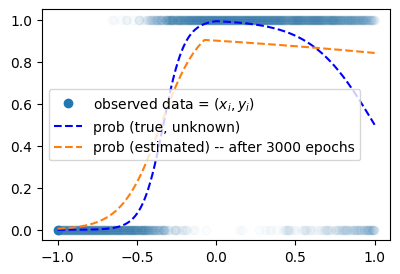

In [111]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x[0],y[0],'o',label= r"observed data = $(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--b',label= r"prob (true, unknown)")
plt.plot(x,net(x).data,'--',label="prob (estimated) -- after 3000 epochs")
plt.legend()

In [112]:
for epoc in range(3000):
    ## 
    yhat = net(x)
    ## 
    loss = loss_fn(yhat,y)
    ## 
    loss.backward()
    ## 
    optimizr.step()
    optimizr.zero_grad()

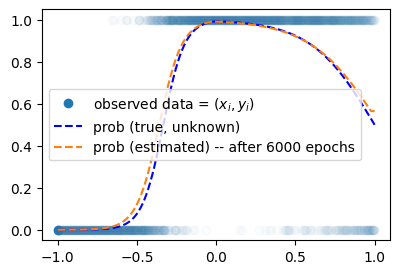

In [113]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x[0],y[0],'o',label= r"observed data = $(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--b',label= r"prob (true, unknown)")
plt.plot(x,net(x).data,'--',label="prob (estimated) -- after 6000 epochs")
plt.legend()